# Import Libraries

In [ ]:
!pip install contractions
!pip install --upgrade keras-nlp
!pip install --upgrade keras
#!pip install --upgrade tensorflow
!pip install tensorflow==2.8.0
!pip install transformers==4.18.0
!pip install keras_tuner


  Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.8.0 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.8.0 which is incompatible.


In [ ]:
import sys
import os

# Print Python version
print("Python version:")
print(sys.version)
print()

# Function to get the name of the virtual environment
def get_environment_name():
    venv = os.getenv('VIRTUAL_ENV')
    if venv:
        return os.path.basename(venv)
    else:
        return "No virtual environment detected"

# Print environment name
print("Environment name:")
print(get_environment_name())


Python version:
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

Environment name:
No virtual environment detected


checking the environment in colab to make sure that it is compatible with the library and program versions.

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
import re

# 3D plotting
from mpl_toolkits.mplot3d import Axes3D

# Scikit-learn
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import keras_tuner as kt

# Transformers and Keras NLP
from transformers import BertTokenizer, TFBertModel
import keras_nlp
import keras.backend as K

# NLTK
import nltk
from nltk.tokenize import word_tokenize
import contractions

# WordCloud
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Initialize the inflect engine
import inflect
p = inflect.engine()

# Constants
MAX_FEATURES = 768
NUM_CLUSTERS = 5
NUM_CLASSES = 6
EPOCHS = 100
BATCH_SIZE = 32
SEED = 0

# Set colormap
cmap = mpl.cm.get_cmap('viridis')

# Ensure reproducibility
np.random.seed(SEED)


<ipython-input-20-e7a8d6d478f9>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis')


This code is setting an environment variable KERAS_BACKEND to either "jax", "tensorflow", or "torch". This variable specifies the backend engine that Keras, a high-level neural networks API, will use for computation.

By setting it to "jax", it indicates that Keras should use the JAX (Just Another eXperimental) backend for computation. JAX is a numerical computing library developed by Google, known for its automatic differentiation and ability to accelerate numerical code on CPUs, GPUs, and TPUs.

Alternatively, setting it to "tensorflow" indicates the use of TensorFlow as the backend, while setting it to "torch" indicates the use of PyTorch as the backend. These are other popular deep learning frameworks that can be used with Keras as the frontend API for building and training neural networks.

# Import Data/EDA

In [ ]:
!pwd

/content


the colab directory that the notebook is running in. This would be important on a group project where other team members might be working on multiple projects.

In [ ]:
essay_df = pd.read_csv('sample_data/train.csv')

# just the first 2000 rows from the data: Proof of concept testing
essay_df = essay_df.iloc[:6000]

essay_df.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


examine the data in Numbers to get a sense of the punctuation or text traits that may need to be addressed in preprocessing. While it's not directly relevant running this program, the preprocessing roadmap was determined in a few steps shown here.

# Preproccessing

Using the roadmap, defining functions to efficiently process each essay. Sets were used to remove discrete words identified later in the process.

In [ ]:
def contains_numeric(token):
  return any(char.isdigit() for char in token)


def convert_numbers_to_words(token):
  if contains_numeric(token):
    # Remove any punctuation from the token before conversion
    # Keeps alphanumeric, whitespace, and "."s, remove anything else
    token = re.sub(r'[^\w\s.]', '', token)

    wordString = p.number_to_words(token).replace(" ", "-")

    #wordString = wordString.replace("-", " ")

    # Tokenize the wordString
    tokens = word_tokenize(wordString)

    return tokens # Return the flat list of tokens instead of a list of lists
  else:
    return [token] # Return the token as a list

# Takes in a raw essay - just a long string
# Outputs a cleaned up list of tokens

def preprocess(rawEssay):
  # Step 1: replace hypens with spaces
  rawEssay = rawEssay.replace("-", " ")

  # Step 2: replace % with the word percent
  rawEssay = rawEssay.replace("%", "percent")

  # Put any other future single character manipulations here

  # Step 3: expand contractions ex: I'm -> I am
  essayExpanded = contractions.fix(rawEssay)

  # Step 4: take the big long string and turn it into tokens (individual strings)
  tokens = word_tokenize(essayExpanded) # just splitting on spaces

  # Step 5: convert the numeric tokens to one or more word tokens
  # ex: 10% -> ['ten', 'percent'] or 1.00 -> ['one', 'point', 'zero', 'zero']
  # use a new array to preserve the order of the tokens
  processedTokens = []

  # leaves non-numeric tokens alone
  for token in tokens:
    processedTokens.extend(convert_numbers_to_words(token))

  # Step 6: remove non-alphabet tokens and lowercase everything
  essayTokens = [word.lower() for word in processedTokens if word.isalpha()]

  # Step 7: remove stop words (common words like 'the', 'and', etc.)
  stop_words = set(nltk.corpus.stopwords.words('english'))
  additional_stop_words = {'would', 'could', 'should'}
  stop_words.update(additional_stop_words)

  essayTokensClean = [word for word in essayTokens if word not in stop_words]

  return essayTokensClean

Normalizing the y (target variable), because neural nets tend to work better calculating when the values are between 0-1.

Visualilze the dataset score distribution.

In [ ]:
def essay_score_dist(essay_df):
    '''
    Creates a bar plot of score counts for each essay based on the 'score' column.

    Input:
    df : Pandas dataframe containing information about essays with a 'score' column

    Output:
    None (Displays a matplotlib figure)
    '''
    # Create a Counter of scores from the available data
    score_bins = Counter(essay_df['score'])

    # Define all bins to display
    all_bins = [1, 2, 3, 4, 5, 6]

    # Create counts for all bins, filling missing bins with zero counts
    counts_per_bin = {bins: score_bins.get(bins, 0) for bins in all_bins}

    # Plot the count of different scores
    plt.figure(figsize=(15, 8))
    bars = plt.bar(counts_per_bin.keys(), counts_per_bin.values(), color='#F4D054')

    plt.ylabel('Frequency')
    plt.xlabel('Essay Score')
    plt.title('Score Distribution', y=1.02)

    # Show the counts on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

    plt.show()

# View dataframe
essay_score_dist(essay_df)

In [ ]:
# Tokenize the essays (part of preprocessing)
essay_df['preprocessed'] = essay_df['full_text'].apply(preprocess)
essay_df['preprocessed_str'] = essay_df['preprocessed'].apply(lambda x: ' '.join(x))

# Normalize scores
def min_max_normalization(score):
    return (score - 1) / (6-1)

essay_df['normalized_score'] = essay_df.apply(lambda row: min_max_normalization(row['score']), axis=1)

essay_df

,essay_id,full_text,score,preprocessed,preprocessed_str,normalized_score
0,000d118,Many people have car where they live. The thin...,3,"[many, people, car, live, thing, know, use, ca...",many people car live thing know use car alot t...,0.4
1,000fe60,I am a scientist at NASA that is discussing th...,3,"[scientist, nasa, discussing, face, mars, expl...",scientist nasa discussing face mars explaining...,0.4
2,001ab80,People always wish they had the same technolog...,4,"[people, always, wish, technology, seen, movie...",people always wish technology seen movies best...,0.6
3,001bdc0,"We all heard about Venus, the planet without a...",4,"[heard, venus, planet, without, almost, oxygen...",heard venus planet without almost oxygen earth...,0.6
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,"[dear, state, senator, letter, argue, favor, k...",dear state senator letter argue favor keeping ...,0.4
...,...,...,...,...,...,...
5995,59dcb0c,Technology to read the emotional expressions o...,2,"[technology, read, emotional, expressions, stu...",technology read emotional expressions students...,0.2
5996,59e32c9,"In the article ""The Challenge of Exploring ven...",2,"[article, challenge, exploring, venus, author,...",article challenge exploring venus author sugge...,0.2
5997,59e3ebc,My position on the driverless cars are definit...,4,"[position, driverless, cars, definitley, whole...",position driverless cars definitley whole idea...,0.6
5998,59e5c22,"Ford, Volkswagen, Kia, and Chevy's... while th...",4,"[ford, volkswagen, kia, chevy, car, brands, ma...",ford volkswagen kia chevy car brands may massi...,0.6


The max_features is the number of words in the corpus, some words are not important so this number could be determined more systematically in the future.

Next, the essays will be clustered by essay prompts. This process was determined by trial and error beginning with 5 clusters and resulting in 7. Perhaps this process could be better optimized in the future.

# Experiment Sections

## Experiment 1: TF-IDF Vector with Neural Net Model

Basic TF-IDF and neural net. This represents the simplest, straightforward, base-model possible using default parameters. Should be excellent at determining the grade.

#### Model Preparation

In [ ]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=768)  # Adjust max_features as needed

# Fit and transform the text data
X = tfidf_vectorizer.fit_transform(essay_df['preprocessed_str']).toarray()

In [ ]:
# Set the seed for reproducibility
np.random.seed(42)

# Generate 5 random indices
random_indices = np.random.choice(essay_df.index, size=5, replace=False)

# Print the full text and preprocessed text for each random row
for index in random_indices:
  print("Row Index:", index)
  print("Full Text:")
  print(essay_df.loc[index, 'full_text'])
  print("\nPreprocessed Text:")
  print(essay_df.loc[index, 'preprocessed'])
  print("\n" + "="*50 + "\n") # add a separator between rows

This is a check with the preprocessed and the full text next to each other to be sure that the preprocessing worked the way that it was suppoed to - the preprocessed text is a list of strings; exactly what we expect.



In [ ]:
# Prepare target labels
#X = np.stack(essay_df['bert_embeddings'].values)
y = essay_df['score'].values
from tensorflow.keras.utils import to_categorical

# One-hot encode the target labels
# The probability predictions need a map to the essay grade/score otherwise the
#neuralnet output is undetermined and doesn't make sense.

# categorical data (score/grade)
# Step 1: Convert grade to integer labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)

# Step 2: Reshape the data to be a 2D array as required by OneHotEncoder
integer_encoded = integer_encoded.reshape(-1, 1)

# Step 3: Apply OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_one_hot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Print the results
print("Original Categories:", y)
print("Integer Encoded:", integer_encoded.ravel())
print("One-Hot Encoded:\n", y_one_hot_encoded)
#.unique

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot_encoded, test_size=0.2, random_state=42)

In [ ]:
# Build and compile model
input_dim = X_train.shape[1] #number of features
#dimensionality of the vectors is specified [1] chooses which feature in the set

#multiclass
#Number of classes
num_classes = y_one_hot_encoded.shape[1] #number of classes


# Build and compile a simple Keras model for multiclass classification
#like specificying how each split decision is made in a decision tree
inputs = Input(shape=(input_dim,)) #input layer; shape 768 dimensions; setting up an empty framework
x = Dense(128, activation='relu')(inputs) # x=hidden layer; each input gets an additional hidden layer added to the previous group
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Softmax activation for multiclass classification


model = Model(inputs=inputs, outputs=outputs)

#multiclass
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

#### Model Training

In [ ]:
# step 4: Build and Train the Neural Network
# Train the model
# Train the Keras model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, validation_split=0.2)

#multiclass

# Predictions on training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print (y_train_pred)
print (y_test_pred)

#predictions are probabilities of which class (grade) the essay will be placed in

In [ ]:
# Convert probabilities to class predictions
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

print(y_train_pred_classes)
print(y_test_pred_classes)
print(y)
print(y_one_hot_encoded)

In [ ]:
# Convert integer labels to original categories
predicted_categories_train = label_encoder.inverse_transform(y_train_pred_classes)
predicted_categories_test = label_encoder.inverse_transform(y_test_pred_classes)
print(predicted_categories_train)
print(predicted_categories_test)

These are great baseline accuracy scores to compare to other more advanced models.

In [ ]:
# Calculate accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(np.argmax(y_train, axis=1), y_train_pred_classes)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred_classes)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


#### Final Evaluation

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot the training and validation accuracy/loss over epochs
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Data is not consistent (accuracy is not high, orange; loss orange is perfect with a minimum on the curve) to investigate add more layers and nodes and see if the orange gets better.

more loss is bad so because the orange loss increases over the epochs, it stays steady on the accuracy (not improving).

This shows overfitting, but there's a promising model to extract because there is a part of the loss curve that has a negative slope. How could we extend this part of the curve?

## Experiment 2: TF-IDF Vector with K-Means Model

Should perform well predicting clusters not grades (what the essay is about)

#### Model Preparation

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


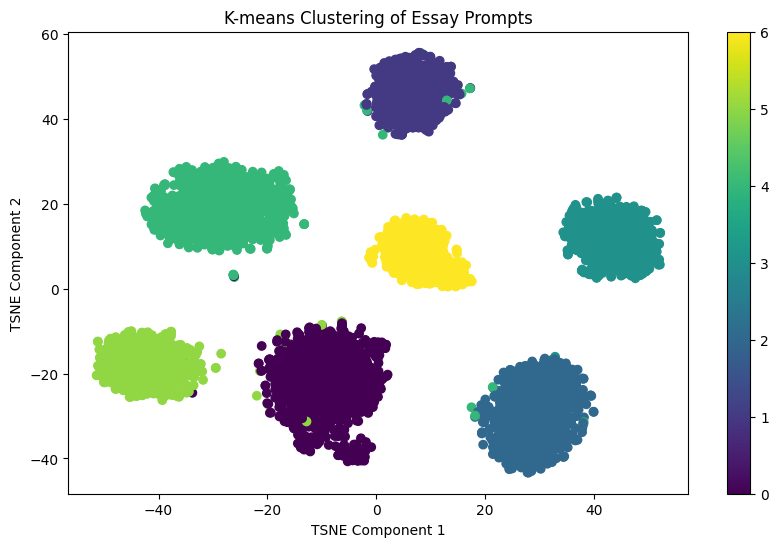

In [ ]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=768)  # Adjust max_features as needed

# Fit and transform the text data
X = tfidf_vectorizer.fit_transform(essay_df['preprocessed_str']).toarray()

# Apply k-means clustering
num_clusters = 7 #specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
essay_df['cluster'] = kmeans.fit_predict(X)

# Visualize the clusters
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=essay_df['cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.title('K-means Clustering of Essay Prompts')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()


There is noise in the system and so this noise could account for the few misclassified essay assignments. Because this visualization is a vector dimension reduction there could be artifacts that impact that cluster grouping. The purple cluster may pose a two sided question which is why there is a larger and smaller cluster so close together (agree/disagree type question).

In [ ]:
def generate_word_cloud(text, num_cluster):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Topic: {}'.format(num_cluster))
    plt.show()

def generate_bar_plot(text, num_cluster):
    # Preprocess the text to remove non-alphabetic characters and convert to lower case
    words = re.findall(r'\b\w+\b', text.lower())

    # Count the frequency of each word
    word_counts = Counter(words)

    # Get the 5 most common words and their frequencies
    most_common_words = word_counts.most_common(5)

    # Separate the words and their frequencies for plotting
    words, frequencies = zip(*most_common_words)

    # Get colors from colormap
    colors = [cmap(i / len(words)) for i in range(len(words))]

    # Create the bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(words, frequencies, color=colors)

    # Add title and labels
    plt.title('Top 5 Words in Topic: {}'.format(num_cluster))
    plt.xlabel('Words')
    plt.ylabel('Frequency')

    # Display the plot
    plt.show()

A word cloud and bar chart will be useful in visualizing the essay prompt topics. This is based on word frequency.

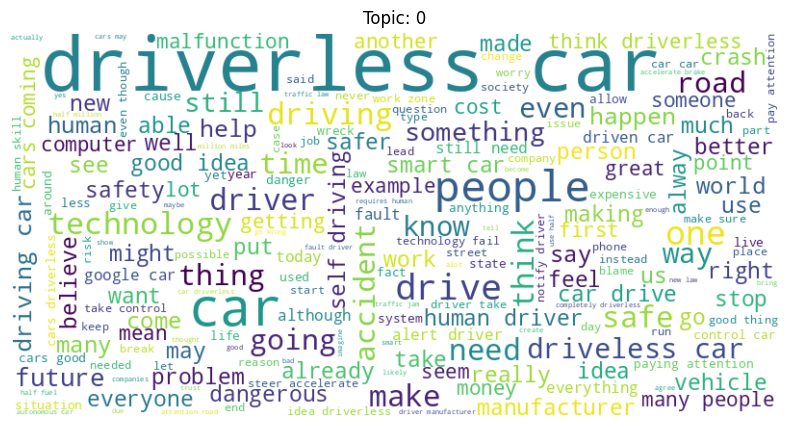

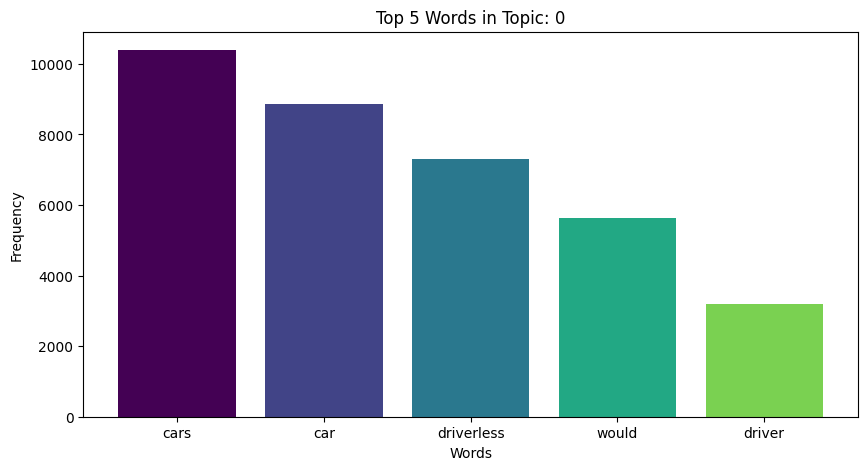

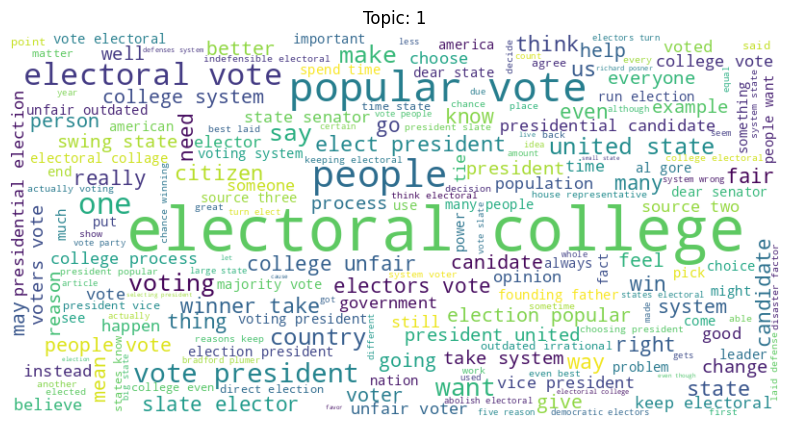

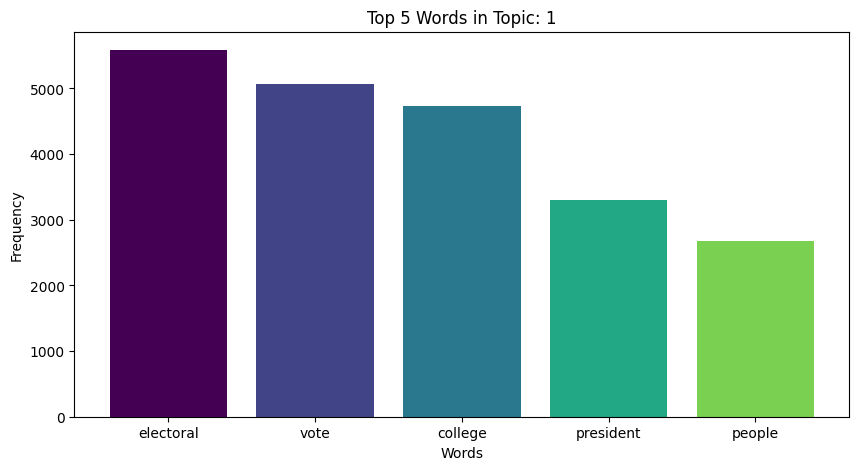

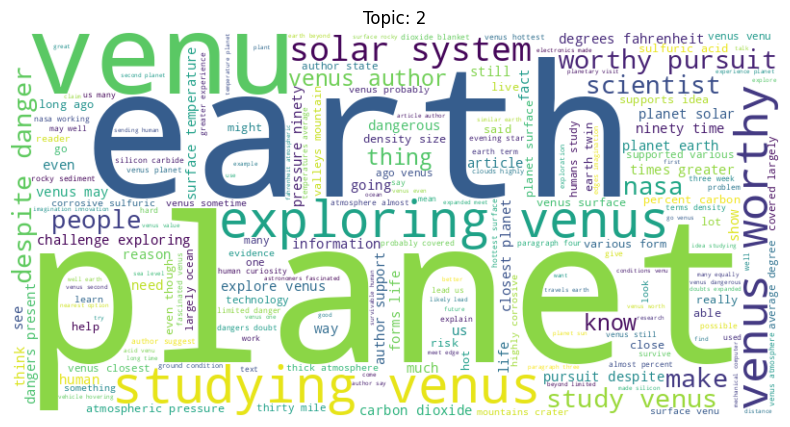

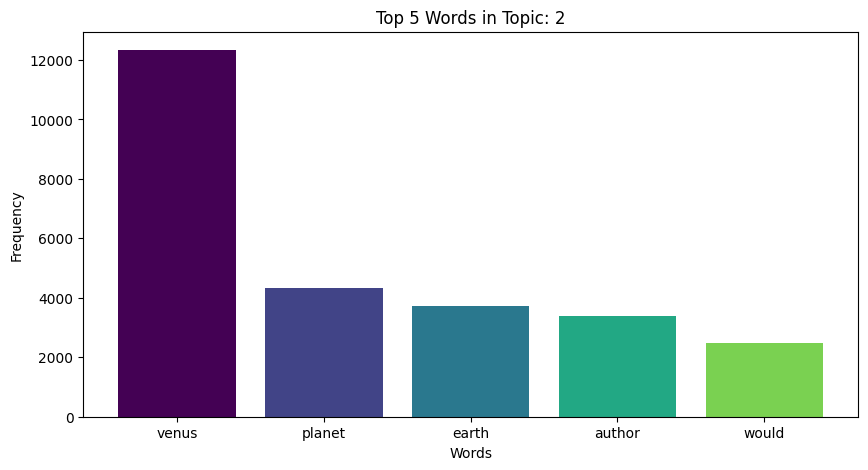

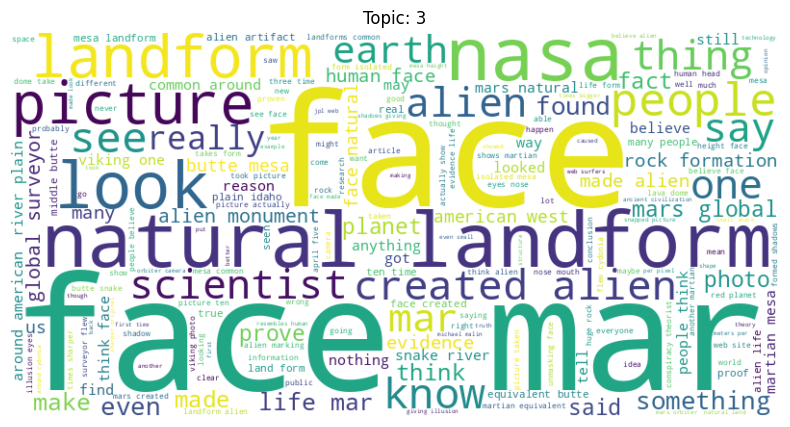

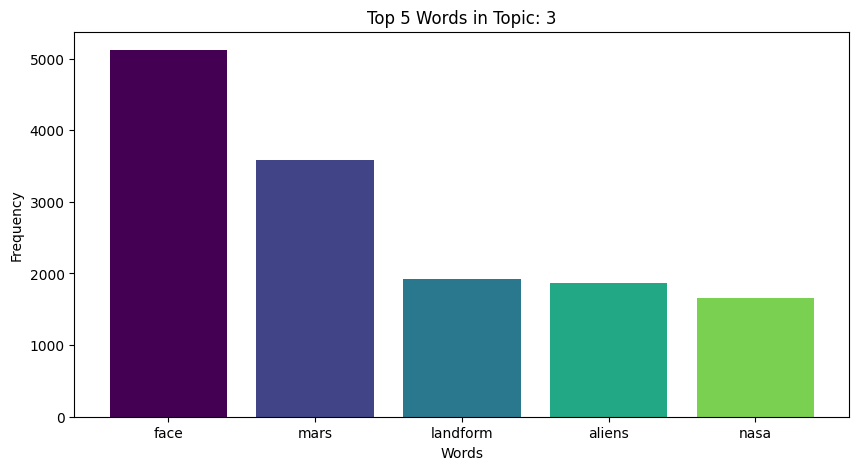

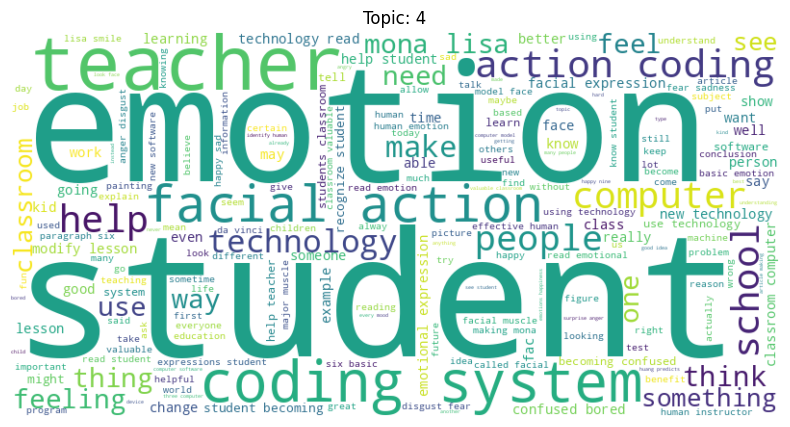

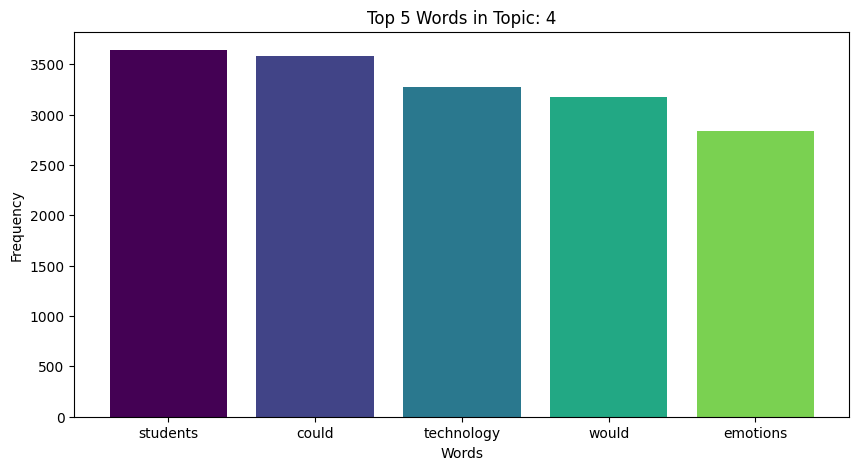

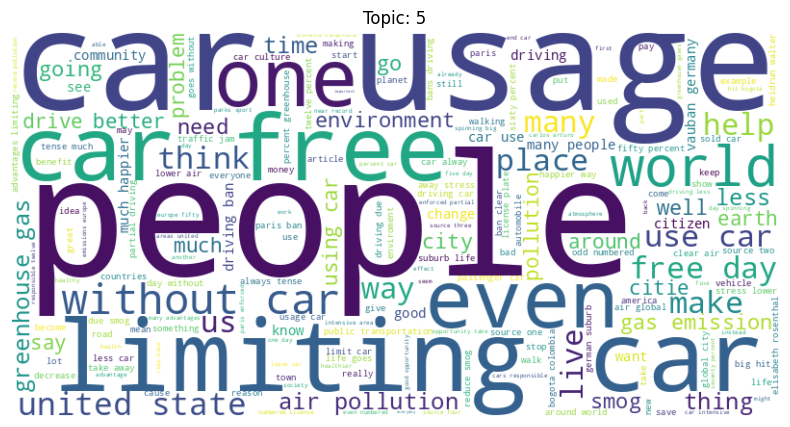

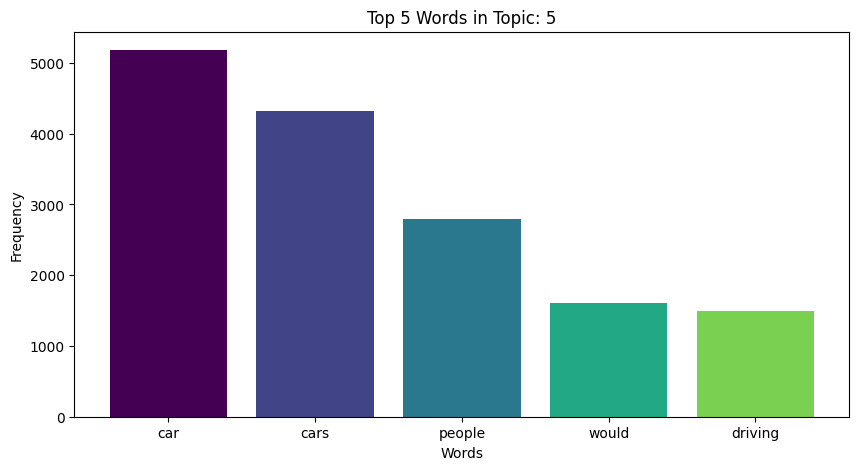

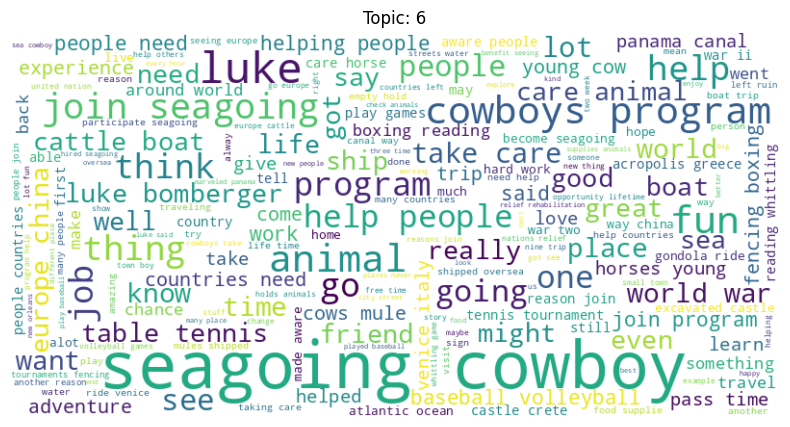

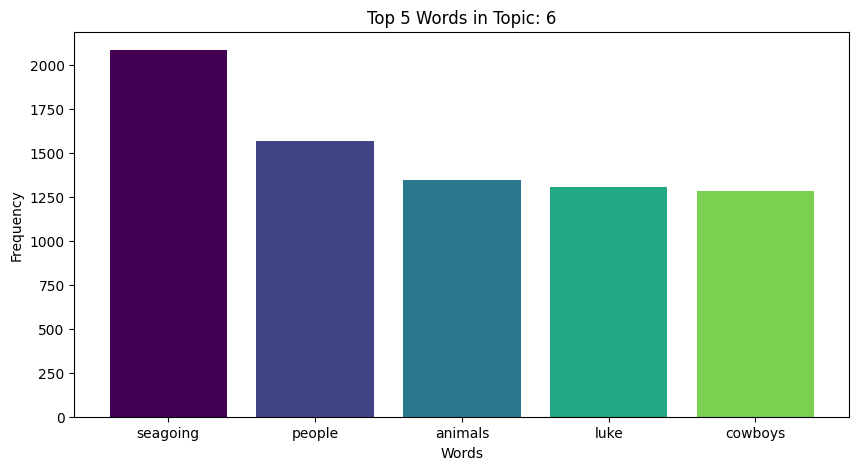

In [ ]:
essay_df['cluster']

for i in range (num_clusters):
 cluster_lists = ' '.join(essay_df[essay_df['cluster'] == i]['preprocessed_str'])
# Generate and display the word cloud
 generate_word_cloud(cluster_lists, i)
# Generate a ranked bar plot of words
 generate_bar_plot(cluster_lists, i)


At this point, it's smart to spot check the data that will be used for the neural net training.

This is a check with the preprocessed and the full text next to each other to be sure that the preprocessing worked the way that it was suppoed to - the preprocessed text is a list of strings; exactly what we expect.

In [ ]:
# Set the seed for reproducibility
np.random.seed(42)

# Generate 5 random indices
random_indices = np.random.choice(essay_df.index, size=5, replace=False)

# Print the full text and preprocessed text for each random row
for index in random_indices:
    print("Row Index:", index)
    print("Full Text:")
    print(essay_df.loc[index, 'full_text'])
    print("\nPreprocessed Text:")
    print(essay_df.loc[index, 'preprocessed'])
    print("\nTopic:", essay_df.loc[index, 'cluster'])
    print("\n" + "=" * 50 + "\n")  # add a separator between rows


Row Index: 1782
Full Text:
Car alarms, car horns, and engines are basically the only thing people hear nowadays. The number of cars in the streets are simply begining to get out of hand.

Citizens all around the world, we all should really try to limit the amount of time that we are spending using our vehicals.

If you really take a moment to think about it, this could honestly turn out to be a really good thing.

Cars are not neccisarily a need, they are a want. I can undertand if you are going to be traveling a far distance that two feet cant get you, but certianlty and ten minute walk to the grocery store/market cant hurt.

Limiting car usage is very important. Most families tend to spend about about $20-50.00 on gas a week. One advantage to limiting car usuage is saving a ton of money on gas that could easily be spent of food, to feed your family.

" "

When I had a car I was always tense. I'm much happier this way" " People who have decided to limit the amount of time they spent u

One-hot encoding the target labels are used because the output is categorical. Probability predictions need a map to the essay grade/score otherwise the neuralnet output is **undetermined** and doesn't make sense. lead to fasle data. change the undetermined to another word.

In [ ]:
# Prepare target labels
y = essay_df['score'].values
from tensorflow.keras.utils import to_categorical

# categorical data (score/grade)
# Step 1: Convert grade to integer labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)

# Step 2: Reshape the data to be a 2D array as required by OneHotEncoder
integer_encoded = integer_encoded.reshape(-1, 1)

# Step 3: Apply OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_one_hot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Print the results
print("Original Categories:", y)
print("Integer Encoded:", integer_encoded.ravel())
print("One-Hot Encoded:\n", y_one_hot_encoded)
#.unique

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot_encoded, test_size=0.2, random_state=42)

Original Categories: [3 3 4 ... 4 4 4]
Integer Encoded: [2 2 3 ... 3 3 3]
One-Hot Encoded:
 [[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Keras Tuner's RandomSearch (jumps around until it finds optimal hyperparameter) - useful because doesn't get stcuk in local minimums where other algorithms can, BayesianOptimization (like gradient descent), and Hyperband are search methods to find the optimal hyperparameters.

When determining the optimal hyperparameters for a neural network, it's crucial to understand the impact of the number of hidden layers, the number of units in each layer, the dropout rates, and the optimizer used. These hyperparameters can significantly affect the model's performance, including its ability to generalize without overfitting or underfitting. Here's how this notebook uses the print statements to accomplish this:
Extraction: the number of layers, units per layer, dropout rates per layer, and the optimizer used from the best hyperparameters.
Informative Print Statements: Provide detailed print statements to give insights into the optimal architecture found by the tuner.
Optional Retraining: Retrain the model with the best hyperparameters to see the final performance, which can be useful for verification purposes.

The neural net model where the number of layers is being fine tuned based on the best hyperparameters possible determined from bayesian optimization.

In [ ]:
# Number of classes
num_classes = y_one_hot_encoded.shape[1]  # number of classes

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=1024, step=16),
                    activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(hp.Float('dropout_input', min_value=0.2, max_value=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=1024, step=16),
                        activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Using Bayesian Optimization for hyperparameter tuning
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=None,
    alpha=0.0001,
    beta=2.6,
    seed=42,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Gather details about the best hyperparameters
num_layers = best_hps.get('num_layers')
layer_units = [best_hps.get(f'units_{i}') for i in range(num_layers)]
dropout_rates = [best_hps.get(f'dropout_{i}') for i in range(num_layers)]
optimizer = best_hps.get('optimizer')

print(f"""
The hyperparameter search is complete. The optimal hyperparameters are:
- Units in the input layer: {best_hps.get('units_input')}
- Number of hidden layers: {num_layers}
- Dropout rate for input layer: {best_hps.get('dropout_input')}
- Optimizer: {optimizer}
""")

for i in range(num_layers):
    print(f"""
    Hidden Layer {i + 1}:
    - Units: {layer_units[i]}
    - Dropout rate: {dropout_rates[i]}
    """)
# step 4: Build the model with the best hyperparameters and train it
# Retrain the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))


Trial 10 Complete [00h 00m 14s]
val_accuracy: 0.3683333396911621

Best val_accuracy So Far: 0.4841666519641876
Total elapsed time: 00h 03m 52s

The hyperparameter search is complete. The optimal hyperparameters are:
- Units in the input layer: 992
- Number of hidden layers: 2
- Dropout rate for input layer: 0.2
- Optimizer: rmsprop


    Hidden Layer 1:
    - Units: 256
    - Dropout rate: 0.2
    

    Hidden Layer 2:
    - Units: 960
    - Dropout rate: 0.30000000000000004
    
Epoch 1/100
150/150 [==============================] - 7s 38ms/step - loss: 1.3549 - accuracy: 0.3885 - val_loss: 1.2024 - val_accuracy: 0.4492
Epoch 2/100
150/150 [==============================] - 3s 21ms/step - loss: 1.1327 - accuracy: 0.4908 - val_loss: 1.1746 - val_accuracy: 0.4650
Epoch 3/100
150/150 [==============================] - 3s 21ms/step - loss: 0.9550 - accuracy: 0.5867 - val_loss: 1.2321 - val_accuracy: 0.4725
Epoch 4/100
150/150 [==============================] - 3s 21ms/step - loss: 0.7649 

#### Model Training


The training accuracy score is way over the testing accuracy score so it's overfitting the data to the model. The model is memorizing the data and not generalizing. Would tweaking the model reduce the overfitting? (fewer epochs?, tuning the optimizer?, etc)

Could adding more layers with more dimensions to get rid of overfitting? (hundreds of layers?) deep learning?

In [ ]:
# Calculate accuracy
train_accuracy = model.evaluate(X_train, y_train)
print(f'Train Accuracy: {train_accuracy}')
test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

150/150 [==============================] - 1s 5ms/step - loss: 8.3539e-05 - accuracy: 1.0000
Train Accuracy: [8.353874727617949e-05, 1.0]
38/38 [==============================] - 0s 5ms/step - loss: 14.4595 - accuracy: 0.4292
Test Accuracy: [14.45946979522705, 0.42916667461395264]


#### Final Evaluation

38/38 [==============================] - 0s 5ms/step - loss: 14.4595 - accuracy: 0.4292
Test Loss: 14.45946979522705
Test Accuracy: 0.42916667461395264


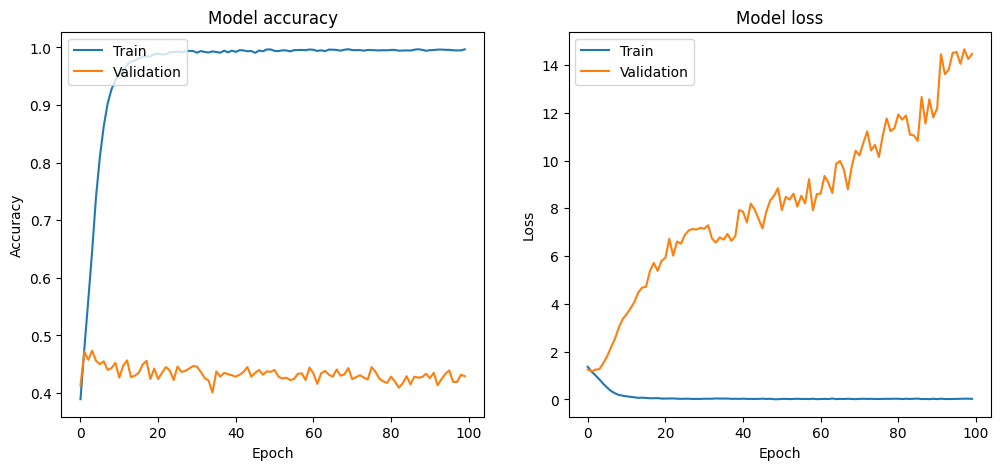

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot the training and validation accuracy/loss over epochs
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Test Accuracy = Validation
The first 1-2 trainings seem to be the best for the testing.

## Experiment 3: BERT Vector and Model

Should be better at determining the grade if accuracy of the models is the goal. High scores are hard but can be compared between these models. Data is complex. BERT is a better vector than TF-IDF. (1-2 compare vectorizers)


#### Model Preparation

Here a Bert Tokenizer is used. The Bert (Bidirectional Encoder Representations from Transformers) is a pre-trained transformer-based model for natural language understanding tasks, trained on large amounts of text data.

Transformer-based models (like BERT), can capture intricate nuances in language usage, context, and semantics. BERT excels in understanding the relationships between different parts of the text and can provide nuanced assessments aligned with the criteria of the rubric. Additionally, the bidirectional nature allows BERT to consider the entire context of the essay when making scoring decisions.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def bert_vectorizer(text):
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True)
    outputs = bert_model(inputs)
    return tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy().squeeze()



In [ ]:
# just the first 2000 rows from the data: due to size of RAM needed
#this is where the shared and BERT data frame split
essay_df_BERT = essay_df.iloc[:2000]

# Vectorize!
essay_df_BERT['bert_embeddings'] = essay_df_BERT['preprocessed_str'].apply(bert_vectorizer)


In [ ]:
essay_df

info check: for the first essay, did the Bert imbedding work? did it do what we expected it to? Let's check the difference between the preprocessing and the bert embedding data. It's a high dimenstional vector (768 coordinates) ... is the output what we expect to see? The output dimensions of BERT are 768-dimensional.



In [ ]:
# Print the full content of the 'bert_embeddings' column for the first row
bert_embeddings = essay_df_BERT.loc[0, 'bert_embeddings']
print(bert_embeddings)
print(len(bert_embeddings))

looks good - one vector with 768 dimensions. This is what we expected the function to output.

In [ ]:
# Set the seed for reproducibility
np.random.seed(42)

# Generate 5 random indices
random_indices = np.random.choice(essay_df_BERT.index, size=5, replace=False)

# Print the full text and preprocessed text for each random row
for index in random_indices:
  print("Row Index:", index)
  print("Full Text:")
  print(essay_df_BERT.loc[index, 'full_text'])
  print("\nPreprocessed Text:")
  print(essay_df_BERT.loc[index, 'preprocessed'])
  print("\n" + "="*50 + "\n") # add a separator between rows

This is a check with the preprocessed and the full text next to each other to be sure that the preprocessing worked the way that it was suppoed to - the preprocessed text is a list of strings; exactly what we expect.

In [ ]:
# Prepare the data for Keras model
X = np.stack(essay_df_BERT['bert_embeddings'].values)
y = essay_df_BERT['score'].values
from tensorflow.keras.utils import to_categorical

# One-hot encode the target labels
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# categorical data (score/grade)
# Step 1: Convert grade to integer labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)

# Step 2: Reshape the data to be a 2D array as required by OneHotEncoder
integer_encoded = integer_encoded.reshape(-1, 1)

# Step 3: Apply OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_one_hot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Print the results
print("Original Categories:", y)
print("Integer Encoded:", integer_encoded.ravel())
print("One-Hot Encoded:\n", y_one_hot_encoded)
#.unique

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot_encoded, test_size=0.2, random_state=42)

When fine-tuning transformer-based models like BERT for essay scoring to align with a grading rubric, several hyperparameters can be adjusted to optimize performance:

Learning Rate: This hyperparameter controls the step size during the optimization process. It can be tuned to ensure that the model learns at an appropriate pace, effectively updating its parameters to minimize the loss function.

Batch Size: The batch size determines the number of samples processed in each training iteration. Adjusting this hyperparameter can impact the model's generalization ability and training speed.

Number of Training Epochs: The number of training epochs specifies how many times the entire training dataset is passed through the model. Fine-tuning may require experimenting with different numbers of epochs to achieve optimal performance without overfitting.

Dropout Rate: Dropout is a regularization technique that randomly drops a fraction of input units during training to prevent overfitting. Tuning the dropout rate can help balance model complexity and generalization.

Layer-specific Hyperparameters: Some transformer architectures, such as BERT, have multiple layers with their own hyperparameters, such as the number of attention heads, hidden units, and feedforward layer sizes. Fine-tuning these parameters can be beneficial for adapting the model to specific tasks and datasets.

In [ ]:
# Build and compile a simple Keras model
input_dim = X_train.shape[1] #number of features
#dimensionality of the vectors is specified [1] chooses which feature in the set

#multiclass
#Number of classes
num_classes = y_one_hot_encoded.shape[1] #number of classes


# Build and compile a simple Keras model for multiclass classification
#like specificying how each split decision is made in a decision tree
inputs = Input(shape=(input_dim,)) #input layer; shape 768 dimensions; setting up an empty framework
x = Dense(128, activation='relu')(inputs) # x=hidden layer; each input gets an additional hidden layer added to the previous group
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Softmax activation for multiclass classification


model = Model(inputs=inputs, outputs=outputs)

#multiclass
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#optimizer = AdamW(model.parameters(), lr=learning_rate), consider tuning these in future

model.summary()

#### Model Training

Predictions are probabilities of which class (grade) the essay will be placed in

In [ ]:
# step 4: Build and Train the Neural Network Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=32, validation_split=0.2)

#multiclass
# Predictions on training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print (y_train_pred)
print (y_test_pred)



In [ ]:
# Convert probabilities to class predictions
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

print(y_train_pred_classes)
print(y_test_pred_classes)
print(y)
print(y_one_hot_encoded)

Here we were confirming that the data was decoded correctly. When the data is encoded, it's hard to know exactly what is going on.

In [ ]:
# Convert integer labels to original categories
predicted_categories_train = label_encoder.inverse_transform(y_train_pred_classes)
predicted_categories_test = label_encoder.inverse_transform(y_test_pred_classes)
print(predicted_categories_train)
print(predicted_categories_test)

In [ ]:
# Calculate accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(np.argmax(y_train, axis=1), y_train_pred_classes)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred_classes)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


This data looks good.

#### Model Evaluation

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot the training and validation accuracy/loss over epochs
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

A plot that looks like this is a reasonable training scheme. The loss has a minimum which means that there is an optimal training timesclae to prevent overfitting. The X axis the amount of training and there seems to be a training sweetspot (more epoch is more training) too many epochs = overfitting.

# Summary


### Limitations

The essays were originally graded by many humans leading to subjective intrepretation of the grading rubric.

References

1. https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/
2. https://www.kaggle.com/
3. https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview
4. https://www.kaggle.com/code/raviiloveyou/sbert-aes/notebook
5. https://www.kaggle.com/code/awsaf49/aes-2-0-kerasnlp-starter
6. https://storage.googleapis.com/kaggle-forum-message-attachments/2733927/20538/Rubric_%20Holistic%20Essay%20Scoring.pdf
7. https://www.tensorflow.org/guide/keras/training_with_built_in_methods
8. https://keras.io/api/utils/
9. https://keras.io/search.html?query=from%20keras.utils%20import%20to_categorical
10. https://keras.io/search.html?query=to_categorical
11. https://huggingface.co/transformers/v3.0.2/main_classes/model.html#transformers.PreTrainedModel.from_pretrained
12. https://www.youtube.com/watch?v=JJYZ3OE_lGo
13. https://www.youtube.com/watch?v=p6yvuST_6oQ
14. https://medium.com/nlplanet/a-brief-timeline-of-nlp-from-bag-of-words-to-the-transformer-family-7caad8bbba56
15. https://keras.io/keras_nlp/
16. https://www.nltk.org/howto/framenet.html
17. https://medium.economist.com/why-you-sometimes-need-to-break-the-rules-in-data-viz-4d8ece284919
18. https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/
19. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer
20. https://sbert.net/#:~:text=Sentence%20Transformers%20(a.k.a.,%2DEncoder%20models%20(quickstart).
21. https://towardsdatascience.com/deep-dive-into-the-code-of-bert-model-9f618472353e
22. https://keras.io/api/keras_tuner/tuners/bayesian/
23. https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate

